In [1]:
!pip install gdown

In [2]:
!gdown 1Lb2yPTZ3ryi84u4hdkrZHi9U2Axlfq7Y
!gdown 1A1lx_Vvu_hWPrGtjeNmXlxKbnSvI_hh2
!gdown 1BcRYEKh3pTs-muEL3W-gNycURxQDley2
!gdown 11aD9gL5v2oNpq-i5a7iBqZBAWFRHC-mV

Downloading...
From: https://drive.google.com/uc?id=1Lb2yPTZ3ryi84u4hdkrZHi9U2Axlfq7Y
To: /content/train_result_full.json
100% 2.36M/2.36M [00:00<00:00, 61.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A1lx_Vvu_hWPrGtjeNmXlxKbnSvI_hh2
To: /content/data_full_spoiled_extended.json
100% 1.52M/1.52M [00:00<00:00, 44.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BcRYEKh3pTs-muEL3W-gNycURxQDley2
To: /content/predicted_train_gemma.json
100% 2.18M/2.18M [00:00<00:00, 69.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=11aD9gL5v2oNpq-i5a7iBqZBAWFRHC-mV
To: /content/merged_results_train.json
100% 2.18M/2.18M [00:00<00:00, 122MB/s]


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import json

with open("merged_results_train.json") as f:
    data = json.load(f)

train_text, val_text = [], []
train_labels, val_labels = [], []

# extra_labels = ['bill_payment', 'change_mode', 'change_voice_settings', 'what_ai_name']
# repl_labels = ['min_payment', 'whisper_mode', 'change_volume', 'what_is_your_name']

c = 0
for i in data:
    train_text.append(i["query"])
    if i["predicted"] == "oos":
        c += 1
    # if i["predicted"] in extra_labels:
    #     train_labels.append(repl_labels[extra_labels.index(i["predicted"])])
    # else:
    train_labels.append(i["predicted"])
c

500

In [6]:
len(train_text), len(train_labels)

(15100, 15100)

In [7]:
with open("data_full_spoiled_extended.json") as f:
    data = json.load(f)

len(data), data.keys()

(4, dict_keys(['train', 'val', 'oos_train', 'oos_val']))

In [8]:
def get_ds(data):
    return zip(*data)

def merge_ds(data1, data2):
    return [*next(data1), *next(data2)], [*next(data1), *next(data2)]

val_text, val_labels = merge_ds(get_ds(data["val"]), get_ds(data["oos_val"]))

for text, label in data["oos_train"][-13:]:
    train_text.append(text)
    train_labels.append(label)
# train_text, train_labels = get_ds(data["train"])
# val_text, val_labels = get_ds(data["val"])

In [9]:
len(train_text), len(val_text)

(15113, 3104)

In [10]:
train_classes, val_classes = set(train_labels), set(val_labels)
len(train_classes), len(val_classes)

(151, 151)

In [11]:
classes = list(train_classes | val_classes)

classes[:5], len(classes)

(['play_music',
  'what_are_your_hobbies',
  'are_you_a_bot',
  'find_phone',
  'timezone'],
 151)

In [12]:
with open("classes.txt", "w") as f:
    f.write("\n".join(classes))

In [13]:
from collections import Counter

labels_count = Counter(train_labels)
sorted_labels_count = labels_count.most_common()
print(*sorted_labels_count[:10], sep="\n", end="\n\n\n")
print(*sorted_labels_count[-10:], sep="\n")

('oos', 513)
('restaurant_suggestion', 128)
('update_playlist', 127)
('who_made_you', 125)
('shopping_list_update', 125)
('todo_list_update', 122)
('change_ai_name', 119)
('change_user_name', 115)
('restaurant_reservation', 115)
('pto_balance', 115)


('meal_suggestion', 73)
('what_is_your_name', 68)
('schedule_maintenance', 68)
('user_name', 67)
('smart_home', 67)
('sync_device', 64)
('order', 64)
('play_music', 62)
('next_holiday', 61)
('where_are_you_from', 60)


In [14]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(3407)
torch.cuda.manual_seed_all(3407)

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from peft import LoraConfig, PeftModel, get_peft_model

def load_model(name="microsoft/deberta-v3-base", num_labels=151):
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModelForSequenceClassification.from_pretrained(name, num_labels=num_labels)
    model.to(device)
    # target_modules = ["query_proj", "value_proj", "dense"]
    # config = LoraConfig(
    #     r=16, lora_alpha=16, target_modules=target_modules, lora_dropout=0.1, bias="none", task_type="SEQ_CLS"
    # )
    # lora_model = get_peft_model(model, config).to(device)
    return tokenizer, model

tokenizer, model = load_model("FacebookAI/roberta-base", num_labels=len(classes))
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [16]:
lens = [len(tokenizer(i)["input_ids"]) for i in [*train_text, *val_text]]
sum(lens) / len(lens)

11.09578964703299

In [17]:
max(lens)

37

In [18]:
def preproc(text, tokenizer, max_length=64):
    inputs = tokenizer(
        text,
        max_length=max_length,
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return inputs["input_ids"], inputs["attention_mask"]

preproc(train_text[0], tokenizer)

(tensor([[    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
             47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1]]),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [19]:
train_input_ids, train_attention_mask = zip(*map(lambda x: preproc(x, tokenizer), train_text))
train_input_ids, train_attention_mask = torch.cat(train_input_ids), torch.cat(train_attention_mask)

val_input_ids, val_attention_mask = zip(*map(lambda x: preproc(x, tokenizer), val_text))
val_input_ids, val_attention_mask = torch.cat(val_input_ids), torch.cat(val_attention_mask)
train_input_ids[0]

tensor([    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
           47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1])

In [20]:
label2id = {label: i for i, label in enumerate(classes)}
id2label = {i: label for i, label in enumerate(classes)}
label2id["yes"]

16

In [21]:
train_targets = torch.cat(list(map(lambda x: torch.LongTensor([label2id[x]]), train_labels)))
val_targets = torch.cat(list(map(lambda x: torch.LongTensor([label2id[x]]), val_labels)))
train_targets[0]

tensor(148)

In [22]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(train_input_ids, train_attention_mask, train_targets)
val_ds = TensorDataset(val_input_ids, val_attention_mask, val_targets)
batch_size = 100
train_dl, val_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True), DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

In [23]:
train_ds[0]

(tensor([    0, 12196,  8151,    74,   939,   304,     7,   224,   939,   657,
            47,   114,   939,    58,    41,    24, 21999,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor(148))

In [24]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()

num_training_steps = epochs * len(train_dl)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dl) * 0.5, num_training_steps=num_training_steps)

In [25]:
from tqdm import tqdm
import gc

def train(model, train_dl, criterion, optimizer, scheduler=None):
    model.train()
    train_loss = 0
    for x, atten_mask, y in train_dl:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        atten_mask = atten_mask.to(device)
        out = model(x, attention_mask=atten_mask).logits
        loss = criterion(out, y)
        train_loss += loss.item()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        gc.collect()
        torch.cuda.empty_cache()
    return train_loss / len(train_dl)

In [26]:
from sklearn.metrics import *
import numpy as np

@torch.no_grad()
def val(model, val_dl, criterion):
    model.eval()
    val_loss, val_acc = 0, 0
    for x, atten_mask, y in val_dl:
        x, y = x.to(device), y.to(device)
        atten_mask = atten_mask.to(device)
        out = model(x, attention_mask=atten_mask).logits
        loss = criterion(out, y)
        val_loss += loss.item()
        pred = np.argmax(out.cpu().detach().numpy(), axis=1)
        true = y.cpu().detach().numpy()
        val_acc += accuracy_score(true, pred)
    gc.collect()
    torch.cuda.empty_cache()
    return val_loss / len(val_dl), val_acc / len(val_dl)

In [27]:
best_epoch, best_val_acc = 0, 0
i = 0

train_losses, val_losses, val_accs = [], [], []
for epoch in tqdm(range(1, epochs + 1)):
    print("\n" + "=" * 5 + f"Epoch {epoch}/{epochs}" +  "=" * 5)
    train_loss = train(model, train_dl, criterion, optimizer, scheduler)
    print(f"Train loss {train_loss}\n")
    val_loss, val_acc = val(model, val_dl, criterion)
    model.save_pretrained(f"roberta/epoch_{epoch}")
    if val_acc > best_val_acc:
        best_epoch, best_val_acc = epoch, val_acc
        i = 0
    else:
        i += 1
        if i == 3:
            model.from_pretrained(f"roberta/epoch_{best_epoch}")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"\nVal loss {val_loss} acc {val_acc}")

  0%|          | 0/10 [00:00<?, ?it/s]


=====Epoch 1/10=====
Train loss 2.2180359677264563



 10%|█         | 1/10 [02:29<22:22, 149.21s/it]


Val loss 0.7870195554569364 acc 0.808125

=====Epoch 2/10=====
Train loss 0.5161556244680756



 20%|██        | 2/10 [04:59<19:58, 149.85s/it]


Val loss 0.6544662611559033 acc 0.8371874999999998

=====Epoch 3/10=====
Train loss 0.39579589204176474



 30%|███       | 3/10 [07:30<17:31, 150.23s/it]


Val loss 0.543336650589481 acc 0.8687499999999999

=====Epoch 4/10=====
Train loss 0.29122982041812256



 40%|████      | 4/10 [10:02<15:06, 151.13s/it]


Val loss 0.46736056241206825 acc 0.8868749999999999

=====Epoch 5/10=====
Train loss 0.19780592169416578



 50%|█████     | 5/10 [12:33<12:34, 150.93s/it]


Val loss 0.42897077463567257 acc 0.89875

=====Epoch 6/10=====
Train loss 0.1549893720320573



 60%|██████    | 6/10 [15:05<10:06, 151.50s/it]


Val loss 0.4300589134218171 acc 0.9

=====Epoch 7/10=====
Train loss 0.12489236374140571



 70%|███████   | 7/10 [17:36<07:34, 151.36s/it]


Val loss 0.41278650460299104 acc 0.90875

=====Epoch 8/10=====
Train loss 0.08108641252558875



 80%|████████  | 8/10 [20:07<05:02, 151.22s/it]


Val loss 0.41444434857112356 acc 0.9109375

=====Epoch 9/10=====
Train loss 0.05226597360849969



 90%|█████████ | 9/10 [22:38<02:31, 151.00s/it]


Val loss 0.412692765101383 acc 0.9118750000000001

=====Epoch 10/10=====
Train loss 0.035544957025099154



100%|██████████| 10/10 [25:08<00:00, 150.90s/it]


Val loss 0.42108530509722186 acc 0.9128125000000001


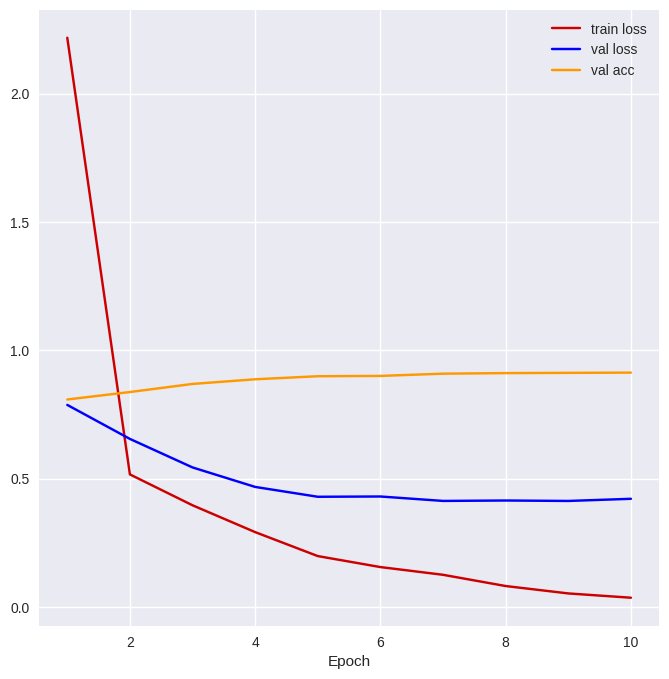

In [28]:
import matplotlib.pyplot as plt

arr_epochs = np.arange(1, epochs + 1)
plt.figure(figsize=(8, 8))
plt.style.use("seaborn-v0_8")
plt.plot(arr_epochs, train_losses, c="#cc0000", label="train loss")
plt.plot(arr_epochs, val_losses, c="#0000ff", label="val loss")
plt.plot(arr_epochs, val_accs, c="#ff9900", label="val acc")
plt.xlabel("Epoch")
plt.legend();

In [29]:
model.from_pretrained(f"roberta/epoch_{best_epoch}", local_files_only=True)
model.to(device)
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [30]:
gc.collect()
torch.cuda.empty_cache()
model.to(device)

preds, trues = [], []
for x, atten_mask, y in val_dl:
    with torch.no_grad():
        x, y = x.to(device), y.to(device)
        atten_mask = atten_mask.to(device)
        out = model(x, attention_mask=atten_mask).logits
        loss = criterion(out, y)
        pred = np.argmax(out.cpu().detach().numpy(), axis=1)
        true = y.cpu().detach().numpy()
        preds.extend(pred)
        trues.extend(true)

gc.collect()
torch.cuda.empty_cache()

In [31]:
label2id["oos"]

119

In [32]:
d = {}
for i in range(len(preds)):
    if preds[i] != trues[i]:
        if id2label[preds[i]] not in d:
            d[id2label[preds[i]]] = 1
        else:
            d[id2label[preds[i]]] += 1

sorted(d.items(), key=lambda x: -x[1])[:10]

[('oos', 73),
 ('shopping_list_update', 11),
 ('todo_list_update', 8),
 ('reminder', 7),
 ('restaurant_reservation', 7),
 ('who_made_you', 6),
 ('freeze_account', 6),
 ('change_user_name', 5),
 ('pto_balance', 5),
 ('what_can_i_ask_you', 5)]

In [33]:
path = "clean"

print(classification_report(trues, preds))
with open(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}_classification_report.txt", "w") as f:
    f.write(classification_report(trues, preds))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       1.00      0.90      0.95        20
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00        20
           4       0.95      1.00      0.98        20
           5       1.00      0.80      0.89        20
           6       1.00      0.80      0.89        20
           7       0.95      1.00      0.98        20
           8       1.00      1.00      1.00        20
           9       0.90      0.45      0.60        20
          10       0.76      0.65      0.70        20
          11       1.00      1.00      1.00        20
          12       1.00      0.70      0.82        20
          13       0.95      1.00      0.98        20
          14       0.87      1.00      0.93        20
          15       1.00      1.00      1.00        20
          16       0.84      0.80      0.82        20
          17       1.00    

In [34]:
!gdown 1UlYk6XdzwK4U1AuPvmBv5i1Odx7K9puZ

Downloading...
From: https://drive.google.com/uc?id=1UlYk6XdzwK4U1AuPvmBv5i1Odx7K9puZ
To: /content/label_desc_context_nearest_many.csv
100% 41.5k/41.5k [00:00<00:00, 94.5MB/s]


In [35]:
import pandas as pd

desc = pd.read_csv("label_desc_context_nearest_many.csv")
desc

,intent,text,description,nearest_labels
0,accept_reservations,does spago in beverly hills allow customers to...,Requests to determine if a specific restaurant...,"['definition', 'travel_alert', 'restaurant_res..."
1,account_blocked,my account looks to be blocked and i have no i...,Requests for information about why a bank acco...,"['balance', 'freeze_account', 'card_declined']"
2,alarm,i'd like alarms set for 11am and 132pm,"Requests to set, update, or review alarms for ...","['translate', 'timer']"
3,application_status,what is the present status of my credit card a...,Requests for updates on the status of an appli...,"['credit_limit', 'order_status', 'credit_limit..."
4,apr,is the apr on my card that ends 1234 what it s...,Requests for information about the Annual Perc...,"['new_card', 'credit_limit', 'interest_rate']"
...,...,...,...,...
146,where_are_you_from,what place were you born at,Requests about the assistant's origin or creat...,"['change_user_name', 'what_can_i_ask_you', 'wh..."
147,whisper_mode,set up whisper mode,"Requests to activate a whisper mode, where the...","['change_user_name', 'change_speed', 'change_v..."
148,who_do_you_work_for,do you work for another person,"Requests to know the assistant's affiliation, ...","['application_status', 'change_user_name', 'wh..."
149,who_made_you,who is your designer,"Requests about the creator, designer, or under...","['fun_fact', 'change_user_name', 'where_are_yo..."


In [36]:
label2desc = {row.intent: row.description for i, row in desc.iterrows() if row.intent != "oos"}
list(label2desc.items())[:5]

[('accept_reservations',
  'Requests to determine if a specific restaurant or establishment allows reservations. Users may seek this information before attempting to book a table.'),
 ('account_blocked',
  'Requests for information about why a bank account or service has been blocked. Users may seek assistance in understanding the reason for the hold and how to resolve it.'),
 ('alarm',
  'Requests to set, update, or review alarms for specific times. Users may provide detailed instructions for single or multiple alarms across different time periods.'),
 ('application_status',
  'Requests for updates on the status of an application, such as a credit card or other formal process. Users may ask if their application has been approved, is under review, or requires additional action.'),
 ('apr',
  'Requests for information about the Annual Percentage Rate (APR) on a credit card. Users may ask if the rate is appropriate based on their credit score or inquire about the APR for a specific card.

In [38]:
# model.push_to_hub("clean-roberta-base")

In [39]:
!mkdir -p "/content/drive/MyDrive/Colab Notebooks/Sirius/project/clean/tokenizer/"

In [40]:
with open(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/tokenizer/label2desc.json", "w") as f:
    json.dump(label2desc, f, indent=2)

In [41]:
# model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/Sirius/project/best")
tokenizer.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/tokenizer/tokenizer")

with open(f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/tokenizer/id2label.json", "w") as f:
    json.dump(id2label, f, indent=2)

In [42]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 102.4 MB/s eta 0:00:00


In [43]:
torch.onnx.export(
    model.cpu(), (torch.rand(1, 5).long(), torch.rand(1, 5).long()),
    f"/content/drive/MyDrive/Colab Notebooks/Sirius/project/{path}/model.onnx",
    input_names=['input_ids', 'attention_masks'],
    output_names=['outputs'],
    opset_version=15,
    dynamic_axes={
        'input_ids': {
            0: 'batch_size',
            1: 'seq_len'
        },
        'attention_masks': {
            0: 'batch_size',
            1: 'seq_len'
        },
        'outputs': {
            0: 'batch_size'
        }
    }
)